# Pink Floyd Lyrics

##### The goal of the project is to analyse all Pink Floyd lyrics, and then build a model that can return a new song based on user input of 2 key words.

#### imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from numpy import array
import sys

from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Bidirectional
import re

In [3]:
!pip install openpyxl

In [4]:
file = "../raw_data/pink_floyd_lyrics.csv"
df = pd.read_csv(file, decimal=",")


### Formatting the DataFrame

In [5]:
df.head()

,album,song_title,year,lyrics
0,The Piper at the Gates of Dawn,Astronomy Domine,1967-08-05,"""Moon in both [houses]...""...Scorpio, [Arabian..."
1,The Piper at the Gates of Dawn,Lucifer Sam,1967-08-05,"Lucifer Sam, siam cat\nAlways sitting by your ..."
2,The Piper at the Gates of Dawn,Matilda Mother,1967-08-05,There was a king who ruled the land\nHis Majes...
3,The Piper at the Gates of Dawn,Flaming,1967-08-05,Alone in the clouds all blue\nLying on an eide...
4,The Piper at the Gates of Dawn,Pow R. Toc H.,1967-08-05,TCH TCH\nAHH (AHH)\nTCH TCH\nAHH AHH\nDoi doi\...


In [6]:

df['year'] = df['year'].apply(lambda x: (x.split('-')[0]))
df.head()

,album,song_title,year,lyrics
0,The Piper at the Gates of Dawn,Astronomy Domine,1967,"""Moon in both [houses]...""...Scorpio, [Arabian..."
1,The Piper at the Gates of Dawn,Lucifer Sam,1967,"Lucifer Sam, siam cat\nAlways sitting by your ..."
2,The Piper at the Gates of Dawn,Matilda Mother,1967,There was a king who ruled the land\nHis Majes...
3,The Piper at the Gates of Dawn,Flaming,1967,Alone in the clouds all blue\nLying on an eide...
4,The Piper at the Gates of Dawn,Pow R. Toc H.,1967,TCH TCH\nAHH (AHH)\nTCH TCH\nAHH AHH\nDoi doi\...


### Explore Data

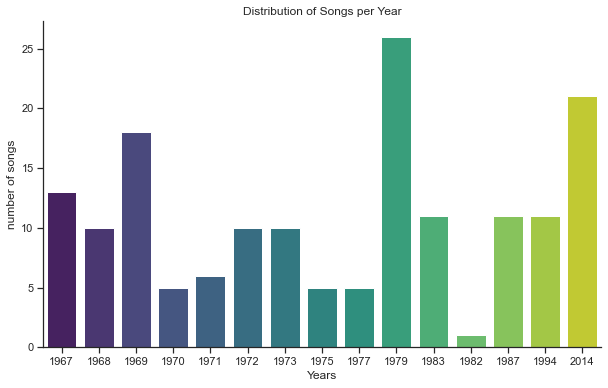

In [81]:
plt.figure(figsize=(10,6),edgecolor='blue')

sns.set_theme(style="darkgrid")
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

f = sns.countplot(x="year", 
                  data=df, 
                  palette="viridis", 
                  saturation=0.75, 
                  dodge=True).set(ylabel='number of songs',xlabel='Years', 
                                  title='Distribution of Songs per Year'
                                                    );


In [79]:
def count_lines(text):
    count,k,p=0,0,0
    for i in text.split('\n'):
        res = re.findall("[a-zA-Z’]+", i)
        if res:
            p+=1
        if len(res)>2:
            k+=1
            count+=len(res)
    if k!=0:
        mean = count/k
    else:
        mean = 2
    total = p
    big_lines = k
    small_lines = (p-k)
  
    return mean,total,big_lines,small_lines

cl = []
for j in range(0,len(df)):
    if type(df.lyrics.iloc[j])==str :
        m,t,bl,sl = count_lines(df.lyrics.iloc[j])
        year = int(df.year.iloc[j])
        if sl!=0:
            l = [m,t,bl,sl,bl/sl,year]
        else:
            l = [m,t,bl,sl,0,year]
        cl.append(l)

df_clines = pd.DataFrame(cl,columns=['mean_lines','total_lines','big_lines','small_lines','ratio_of_blsl','year'])
df_clines.head()

,mean_lines,total_lines,big_lines,small_lines,ratio_of_blsl,year
0,6.071429,15,14,1,14.000000,1967
1,5.571429,16,14,2,7.000000,1967
2,5.409091,28,22,6,3.666667,1967
3,4.600000,20,20,0,0.000000,1967
4,3.500000,10,2,8,0.250000,1967


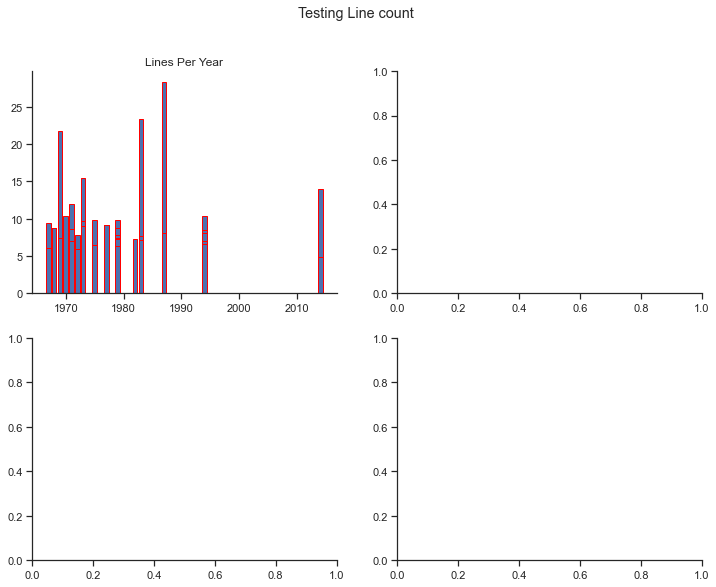

In [84]:
fig,axs = plt.subplots(2,2,figsize=(12,9))
fig.suptitle('Testing Line count')

axs[0,0].bar(df_clines['year'], df_clines['mean_lines'],edgecolor='red')
axs[0,0].set_title('Lines Per Year');



### Start Tokenizing

In [8]:
tokenizer = Tokenizer(char_level=False)
tokenizer.fit_on_texts([df.lyrics.iloc[1].replace('\n',' \n ')])
tokenizer.word_index

{'side': 1,
 'that': 2,
 'cat’s': 3,
 'something': 4,
 'i': 5,
 'can’t': 6,
 'explain': 7,
 'cat': 8,
 'you’re': 9,
 'a': 10,
 'the': 11,
 'be': 12,
 'lucifer': 13,
 'always': 14,
 'by': 15,
 'your': 16,
 'around': 17,
 'sam': 18,
 'siam': 19,
 'sitting': 20,
 'jennifer': 21,
 'gentle': 22,
 'witch': 23,
 'left': 24,
 'he’s': 25,
 'right': 26,
 'oh': 27,
 'no': 28,
 'go': 29,
 'to': 30,
 'sea': 31,
 'hip': 32,
 'ship’s': 33,
 'somewhere': 34,
 'anywhere': 35,
 'at': 36,
 'night': 37,
 'prowling': 38,
 'sifting': 39,
 'sand': 40,
 'hiding': 41,
 'on': 42,
 'ground': 43,
 'he’ll': 44,
 'found': 45,
 'when': 46}

In [9]:
text = df.lyrics.iloc[1].split('\n')
text = [re.sub(r'\d+', '', i) for i in text]
corpus = list(set(text))

In [10]:
corpus


['',
 'Be a hip cat, be a ship’s cat',
 'At night prowling, sifting sand',
 'Hiding around on the ground',
 'Always sitting by your side',
 'You’re the left side, he’s the right side',
 'That cat’s something I can’t explain',
 'Lucifer Sam, siam cat',
 'He’ll be found when you’re around',
 'Always by your side',
 'Somewhere, anywhere',
 'Jennifer Gentle, you’re a witch',
 'Lucifer, go to sea',
 'Oh, no!']

In [11]:
lines=[]

for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    print('--'*25)
    print(token_list)
    print('--'*25)
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        print(n_gram_sequence)

--------------------------------------------------
[]
--------------------------------------------------
--------------------------------------------------
[12, 10, 32, 8, 12, 10, 33, 8]
--------------------------------------------------
[12, 10]
[12, 10, 32]
[12, 10, 32, 8]
[12, 10, 32, 8, 12]
[12, 10, 32, 8, 12, 10]
[12, 10, 32, 8, 12, 10, 33]
[12, 10, 32, 8, 12, 10, 33, 8]
--------------------------------------------------
[36, 37, 38, 39, 40]
--------------------------------------------------
[36, 37]
[36, 37, 38]
[36, 37, 38, 39]
[36, 37, 38, 39, 40]
--------------------------------------------------
[41, 17, 42, 11, 43]
--------------------------------------------------
[41, 17]
[41, 17, 42]
[41, 17, 42, 11]
[41, 17, 42, 11, 43]
--------------------------------------------------
[14, 20, 15, 16, 1]
--------------------------------------------------
[14, 20]
[14, 20, 15]
[14, 20, 15, 16]
[14, 20, 15, 16, 1]
--------------------------------------------------
[9, 11, 24, 1, 25, 11, 

In [19]:
def ngram(token_list):
    ng = []
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        ng.append(n_gram_sequence)
    return ng


In [21]:
df.iloc[[0]].lyrics.iloc[0]

'"Moon in both [houses]..."...Scorpio, [Arabian Skies], Libra..."...Pluto was not discovered until 1930..."\nLime and limpid green, a second scene\nA fight between the blue you once knew\nFloating down, the sound resounds\nAround the icy waters underground\nJupiter and Saturn, Oberon, Miranda and Titania\nNeptune, Titan, stars can frighten\n\nBlinding signs flap\nFlicker, flicker, flicker, blam\nPow, pow\nStairway scare Dan Dare who’s there?\n\nLime and limpid green, the sound surrounds\nThe icy waters under\nLime and limpid green, the sound surrounds\nThe icy waters underground'

In [48]:
len(df)

163

In [49]:
def seqform(data):
  
    tokenise = Tokenizer()
    input_sequences = []
    corpus = []
    k=0

    for i in range(0,len(df)):
    
        text = df.iloc[[i]].lyrics.iloc[0]
        if type(text)==float:
            pass
        else:
            text = text.lower().split("\n")
            text = [re.sub(r'\d+', '', i) for i in text]
            text = list(set(text))
            if text==' ':
                pass
            else:
                corpus.extend(text)
            k+=1
            
    tokenise.fit_on_texts(corpus)
    for line in corpus:
        token_list = tokenise.texts_to_sequences([line])[0]
        input_sequences.extend(ngram(token_list))
 
  
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences,
                       maxlen = max_sequence_len, padding='pre'))
        
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    fin_data = pd.DataFrame(np.hstack((predictors, label.reshape(-1,1))),columns=np.hstack((np.arange(1,predictors.shape[1]+1),np.array(['label']))))
    total_words = len(tokenise.word_index) + 1
    print('{} number of lyrics inputted'.format(k))
        
    return fin_data,tokenise,max_sequence_len,total_words,predictors,label

In [50]:
fdf,tokenise,max_sequence_len,total_words,predictors,label = seqform(df)
print(fdf.shape,max_sequence_len,total_words)

125 number of lyrics inputted
(13839, 88) 88 2983


In [51]:
fdf.head(10)

,1,2,3,4,5,6,7,8,9,10,...,79,80,81,82,83,84,85,86,87,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,356
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,356,296
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,356,296,512
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,513,513
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,356
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,356,296
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,356,296,260
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,833,834
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,833,834,633
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,833,834,633,33


In [52]:
fdf.to_csv('fin_df.csv',index=False)

### Find Params for the model

In [53]:
print(fdf.shape)
print(fdf.values.max())

(13839, 88)
2982


In [54]:
dataX = [fdf.iloc[i,0:87].tolist() for i in range(0,fdf.shape[0])]
dataY = [fdf.iloc[i,87] for i in range(0,fdf.shape[0])]
print(len(dataX))
print(len(dataY))

13839
13839


In [55]:
# reshape X to be [samples, time steps, features]
X = np.reshape(dataX, (13839, 87, 1))

# one hot encode the output variable
y = np_utils.to_categorical(dataY)

In [56]:
len(y[0])
print(predictors.shape)
print(label.shape)
print(X.shape,y.shape)
print(total_words,max_sequence_len)

(13839, 87)
(13839,)
(13839, 87, 1) (13839, 2981)
2983 88


### Designing the Model

In [57]:
model = Sequential()
model.add(Embedding(total_words, 150, input_length=max_sequence_len-1))
# Add an LSTM Layer
model.add(Bidirectional(LSTM(150, return_sequences=True)))  
# A dropout layer for regularisation
model.add(Dropout(0.2))
# Add another LSTM Layer
model.add(LSTM(100)) 
model.add(Dense(total_words/2, activation='relu'))  
# In the last layer, the shape should be equal to the total number of words present in our corpus
model.add(Dense(y.shape[1], activation='softmax'))
#model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')  #(# Pick a loss function and an optimizer)
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 87, 150)           447450    
                                                                 
 bidirectional_1 (Bidirectio  (None, 87, 300)          361200    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 87, 300)           0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               160400    
                                                                 
 dense_2 (Dense)             (None, 1491)              150591    
                                                                 
 dense_3 (Dense)             (None, 2981)              4447652   
                                                      

In [58]:
# define the checkpoint
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [60]:
model.fit(X,y, epochs= 10,callbacks=callbacks_list)

Epoch 1/10
433/433 [==============================] - ETA: 0s - loss: 6.5144 - accuracy: 0.0672
Epoch 00001: loss improved from inf to 6.51442, saving model to weights-improvement-01-6.5144.hdf5
433/433 [==============================] - 155s 358ms/step - loss: 6.5144 - accuracy: 0.0672
Epoch 2/10
433/433 [==============================] - ETA: 0s - loss: 6.0757 - accuracy: 0.0751
Epoch 00002: loss improved from 6.51442 to 6.07571, saving model to weights-improvement-02-6.0757.hdf5
433/433 [==============================] - 152s 352ms/step - loss: 6.0757 - accuracy: 0.0751
Epoch 3/10
433/433 [==============================] - ETA: 0s - loss: 5.8621 - accuracy: 0.0785
Epoch 00003: loss improved from 6.07571 to 5.86209, saving model to weights-improvement-03-5.8621.hdf5
433/433 [==============================] - 133s 308ms/step - loss: 5.8621 - accuracy: 0.0785
Epoch 4/10
433/433 [==============================] - ETA: 0s - loss: 5.6269 - accuracy: 0.0864
Epoch 00004: loss improved from 

### Training the Model on improved weights

In [61]:
filename = "weights-improvement-10-4.5234.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics='accuracy')
model.fit(X, y, epochs=20, callbacks=callbacks_list)

Epoch 1/20
433/433 [==============================] - ETA: 0s - loss: 4.5760 - accuracy: 0.1633
Epoch 00001: loss did not improve from 4.52336
433/433 [==============================] - 145s 323ms/step - loss: 4.5760 - accuracy: 0.1633
Epoch 2/20
433/433 [==============================] - ETA: 0s - loss: 4.2904 - accuracy: 0.1754
Epoch 00002: loss improved from 4.52336 to 4.29039, saving model to weights-improvement-02-4.2904.hdf5
433/433 [==============================] - 139s 320ms/step - loss: 4.2904 - accuracy: 0.1754
Epoch 3/20
433/433 [==============================] - ETA: 0s - loss: 4.1049 - accuracy: 0.1882
Epoch 00003: loss improved from 4.29039 to 4.10493, saving model to weights-improvement-03-4.1049.hdf5
433/433 [==============================] - 139s 321ms/step - loss: 4.1049 - accuracy: 0.1882
Epoch 4/20
433/433 [==============================] - ETA: 0s - loss: 3.9285 - accuracy: 0.1979
Epoch 00004: loss improved from 4.10493 to 3.92851, saving model to weights-improvem

In [63]:
model.save_weights('my_model_weights.h5')
model.save('my_model.h5')


In [65]:
model.save('saved_model/my_model')

2022-07-02 15:12:23.946039: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


### Func to making lyrics

In [67]:
def make_lyrics(seed_text, next_words):
    pred_index=[]
    for i in range(next_words):
        token_list = tokenise.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list],
                     maxlen=max_sequence_len-1,padding='pre')
        #print(token_list.shape)
        token_list = np.reshape(token_list, (1, max_sequence_len-1, 1))
        predicted = model.predict(token_list, verbose=0)
        predicted_index =  np.argmax(predicted)
        pred_index.append(predicted_index)
        
        output_word = ""
        for word, index in tokenise.word_index.items():
            if index == predicted_index:
                output_word = word
                break
        seed_text += " " + output_word
    print(seed_text)
    return seed_text

In [68]:
reverse_word_map = dict(map(reversed, tokenise.word_index.items()))
start = np.random.randint(0, len(dataX)-1)
pattern = dataX[start]
pattern_val = [i for i in pattern if i>0]
print("Seed:")
print(' '.join([reverse_word_map.get(value) for value in pattern_val]))
seed_text = [reverse_word_map.get(value)+' ' for value in pattern_val]

Seed:
plans that either come to naught or


### Playing with the model

In [71]:
line1 = make_lyrics('fear', 15)

fear else is no other in black ni incurable tyrants and kings to grow and high
